### cGAN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import argparse
import os
import numpy as np
import math

In [2]:
seed = 0
torch_seed = torch.manual_seed(seed)

parser =  argparse.ArgumentParser()
parser.add_argument('--n_epochs', type=int, default=200)
parser.add_argument('--batch_size', type=int, default=50)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--b1', type=float, default=0.5)
parser.add_argument('--b2', type=float, default=0.999)
parser.add_argument('--n_cpu', type=int, default=8)
parser.add_argument('--latent_dim', type=int, default=100)
parser.add_argument('--img_size', type=int, default=28)
parser.add_argument('--channels', type=int, default=1)
parser.add_argument('--sample_interval', type=int, default=1000)
parser.add_argument('--condition_size', type=int, default=10)
args = parser.parse_args('')

print(args)


Namespace(n_epochs=200, batch_size=50, lr=0.0001, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=28, channels=1, sample_interval=1000, condition_size=10)


In [3]:
img_shape = (args.channels, args.img_size, args.img_size)
cuda = True if torch.cuda.is_available() else False

In [4]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    def block(input_dim, output_dim, normalize=True):
      layers = [nn.Linear(input_dim, output_dim)]
      if normalize:
        layers.append(nn.BatchNorm1d(output_dim, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers
    
    self.model = nn.Sequential(
      *block(args.latent_dim + args.condition_size, 128, normalize=False),
      *block(128, 256),
      *block(256, 512),
      *block(512, 1024),
      nn.Linear(1024, int(np.prod(img_shape))),
      nn.Tanh()
    )
  
  def forward(self, z, label):
    z_concat = torch.cat((z, label), 1)
    img = self.model(z_concat)
    img = img.view(img.size(0), *img_shape)
    return img


In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(int(np.prod(img_shape)) + args.condition_size, 512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )
  
  def forward(self, img, label):
    img_flatten = img.reshape(args.batch_size, -1)
    img_concat = torch.cat((img_flatten, label), 1)
    validity = self.model(img_concat)

    return validity

In [6]:
# loss function
adversarial_loss = torch.nn.BCELoss() # Binary Coss Entropy

# init generator & discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
  generator = generator.cuda()
  discriminator = discriminator.cuda()
  adversarial_loss = adversarial_loss.cuda()

In [7]:
# configure data loader
os.makedirs('../data/mnist', exist_ok=True)
dataloader = DataLoader(
  datasets.MNIST(
    '../data/mnist',
    train=True,
    download=True,
    transform=transforms.Compose(
      [transforms.Resize(args.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    )
  ),
  batch_size=args.batch_size,
  shuffle=True
)

In [8]:
# optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=args.lr, betas=(args.b1, args.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.lr, betas=(args.b1, args.b2))

# 텐서 변환 함수
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [9]:
os.makedirs("cGAN_img", exist_ok=True)

In [11]:
for epoch in range(args.n_epochs):
  for i, (imgs, labels) in enumerate(dataloader):

    # Adversarial groun truths
    # 진짜 이미지와 가짜 이미지에 대한 정답 레이블 생성
    real = Tensor(imgs.size(0), 1).fill_(1.0)
    fake = Tensor(imgs.size(0), 1).fill_(0.0)

    # configure input
    imgs = imgs.type(Tensor)

    # label encoded
    label_encoded = F.one_hot(labels, num_classes=args.condition_size).type(Tensor)

    # train generator
    optimizer_G.zero_grad()
    
    # noise 생성(flatten tensor)
    z = Tensor(np.random.normal(0, 1, (args.batch_size, args.latent_dim)))
    
    # generator로 이미지 생성
    gen_imgs = generator(z, label_encoded)
    
    # C(D(G(z), real))
    g_loss = adversarial_loss(discriminator(gen_imgs, label_encoded), real)
    
    g_loss.backward()
    optimizer_G.step()
    
    # train discriminator

    optimizer_D.zero_grad()
    
    real_loss = adversarial_loss(discriminator(imgs, label_encoded), real)
    fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), label_encoded.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    optimizer_D.step()

    batches_done = epoch * len(dataloader) + i
    if batches_done % args.sample_interval == 0:
      save_image(gen_imgs.data[:25], f'cGAN_img/{batches_done}.png', nrow=5, normalize=True)
      
  print(f'[EPOCH {epoch}/{args.n_epochs}] [D loss: {d_loss.item():.2f}] [G loss: {g_loss.item():.2f}]')

[EPOCH 0/200] [D loss: 0.29] [G loss: 1.13]
[EPOCH 1/200] [D loss: 0.21] [G loss: 2.32]
[EPOCH 2/200] [D loss: 0.22] [G loss: 3.40]
[EPOCH 3/200] [D loss: 0.25] [G loss: 2.99]
[EPOCH 4/200] [D loss: 0.16] [G loss: 2.57]
[EPOCH 5/200] [D loss: 0.30] [G loss: 1.62]
[EPOCH 6/200] [D loss: 0.25] [G loss: 1.52]
[EPOCH 7/200] [D loss: 0.16] [G loss: 2.96]
[EPOCH 8/200] [D loss: 0.25] [G loss: 4.06]
[EPOCH 9/200] [D loss: 0.53] [G loss: 3.76]
[EPOCH 10/200] [D loss: 0.31] [G loss: 1.32]
[EPOCH 11/200] [D loss: 0.27] [G loss: 1.79]
[EPOCH 12/200] [D loss: 0.34] [G loss: 1.06]
[EPOCH 13/200] [D loss: 0.45] [G loss: 0.98]
[EPOCH 14/200] [D loss: 0.34] [G loss: 1.36]
[EPOCH 15/200] [D loss: 0.52] [G loss: 0.84]
[EPOCH 16/200] [D loss: 0.43] [G loss: 1.90]
[EPOCH 17/200] [D loss: 0.52] [G loss: 0.83]
[EPOCH 18/200] [D loss: 0.33] [G loss: 1.18]
[EPOCH 19/200] [D loss: 0.44] [G loss: 1.46]
[EPOCH 20/200] [D loss: 0.53] [G loss: 2.15]
[EPOCH 21/200] [D loss: 0.43] [G loss: 0.95]
[EPOCH 22/200] [D lo

In [20]:
test_img = torch.empty(0).cuda()
for i in range(10):
  test_label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).cuda()
  test_label_encoded = F.one_hot(test_label, num_classes=10)

  _z = Tensor(np.random.normal(0, 1, (10, args.latent_dim)))
  test_img = torch.cat((test_img, generator(_z, test_label_encoded).flatten()), 0)

result = test_img.reshape(100, 1, 28, 28)
save_image(result, './cGAN_img/test_result.png', nrow=10)


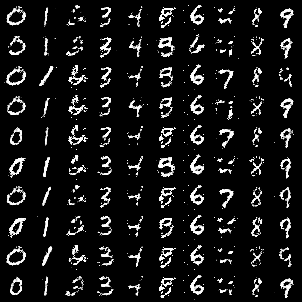

In [21]:
from IPython.display import Image
Image('./cGAN_img/test_result.png')